# Bayesian Deep Learning in Push

## Introduction

In this notebook, we will demonstrate various features of Push by using it to train a **deep ensemble** on a sine wave:

\begin{gather}
    y & = sin(2\pi x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{gather}

A deep ensemble is one of many methods for performing **Bayesian deep learning** (BDL). BDL applies **Bayesian inference** to neural networks (NNs) in the hopes of enabling additional capabilities such as **uncertainty quantification**. For more background on BDL, we recommend Kevin Murphy's excellent book "Probabilistic Machine Learning: Advanced Topics, Kevin Murphy, Chapter 17" on BDL.

### Dataset

We set up the sine wave dataset now with $D = 1$ dimensions defined on the interval $(-2\pi, 2\pi)$ with $N = 12 \cdot 64$ data points.

In [1]:
import math
from bdl import SineWithNoiseDataset


D = 1                                  # dimensions
N = 2048                                # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

### Plotting the Dataset 

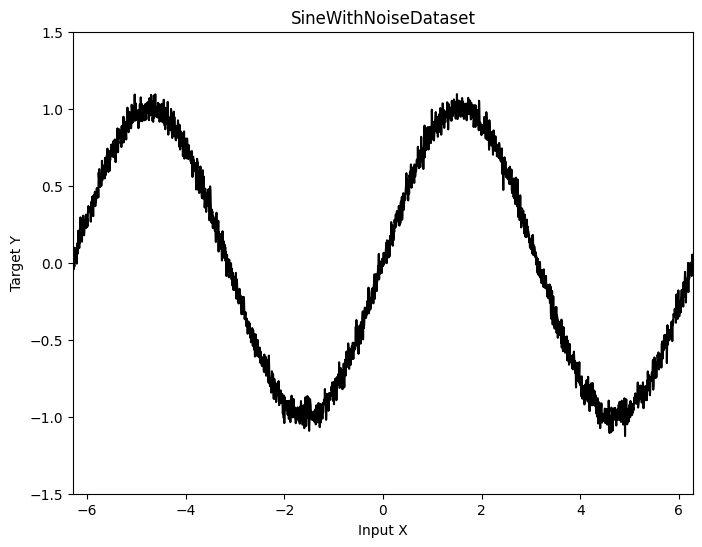

In [2]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('SineWithNoiseDataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

## Defining Models in Push with Particles

Users can represent a Bayesian neural network (BNN) in Push as a concurrently-executing and communicating ensemble of **particles**. This consists of two components.
1. Push provides functionality to wrap an arbitrary PyTorch module as a **particle**. This enables Push users to use a wide range of predefined models.
2. Push enables orchestrating ensembles of particles, concurrent execution of particles, and communications between particles using the `PusH` construct.

### Model Part 1: Neural Network Architecture Template

For the purposes of this tutorial, we introduce a simple neural network (NN) model now. This NN architecture will be used as a template to create instances of particles.

In [3]:
# Import the neural network
from bdl import MiniNN, BiggerNN

Each `MiniNN` contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. The code is contained in the module `bdl`.
```py
class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x 
```

A `BiggerNN` is built out of $n$ `MiniNN` NN blocks so we can vary the size of the network to explore how the number of layers affects our results. 
```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)
```

### Model Part 2: Ensemble of Particles

The construct `PusH` enables Push users to orchestrate a communicating ensemble of particles. The `PusH` object runs on a separate process from the calling process so that it can execute the semantics of particles separately from the calling process. We give an example of calling `PusH` with the arguments below now.

1. `num_ensembles`: determines the number of particles to create.
2. `mk_nn`: the NN architecture used as a template to create particles.
3. `*args`: the hyperparameters for the NN architecture. For a `BiggerNN`, this includes the number of `MiniNN` layers, the size of the input dimension, the size of the output dimension, and the size of the hidden dimension.
4. `cache_size`: the maximum number of particles to hold in GPU memory per device at a time. This should be set to handle GPU memory management. We will discuss this further in a more advanced tutorial.
5. `view_size`: the maximum number of particles that are viewable from any single particle at a time. This should be set to handle GPU memory management. We will discuss this further in a more advanced tutorial.

```py
import push.push

def push_dist_example(num_ensembles, mk_nn, *args, cache_size=8, view_size=8):
    # Create a communicating ensemble of particles using mk_nn as a template
    with push.push.PusH(mk_nn, *args, cache_size=cache_size, view_size=view_size) as push_dist:
        pids = []
        for i in range(num_ensembles):
            # 1. Each particle has a unique `pid`.
            # 2. `mk_optim` is a particle specific optimization method as in standard PyTorch.
            # 3. Create a particle on device 0.
            # 4. `receive` determines how each particle .
            # 5. `state` is the state associated with each particle.
            pids += [push_dist.p_create(mk_optim, device=0, receive={}, state={})]

num_ensembles = 4
input_dim = 1
output_dim = 1
hidden_dim = 64
n = 4
push_dist_example(num_ensembles, BiggerNN, n, input_dim, output_dim, hidden_dim)
```

## Training Models in Push

After we have defined a `PusH` object, we can use the orchestration capabilities of Push to train each particle, possibly with interaction between different particles during training. In this tutorial, we choose one of the simplest methods--deep ensembles--where there is no communication between different particles.

### Training Deep Ensembles in Push

A deep ensemble with $k$ ensembles trains $k$ instances of a NN architecture to obtains $k$ independently-trained models. Each trained model can be interpreted as the parameter setting corresponding to a sample from a suitably defined posterior distribution on NN parameters. In this way, a deep ensemble can be seen as a BDL method. To run a deep ensemble we will be using the `bayes.ensemble.train_deep_ensemble` function. This function requires the following to run.

1. A **dataloader** (`torch.utils.data`)
2. A **loss** function i.e. (`torch.nn.MSELoss`)
3. The number of **epochs** (`int`)
4. A **model** class (`torch.nn.Module`)
5. The model class's initialization parameters
6. The number of **devices** (GPUs) to use (`int`)
7. The number of **models** to be ensembles (`int`)

and returns a list of particle parameters. Where each item in the list pertains to a single particle parameter setting.

```python
def train_deep_ensemble(dataloader: Callable, loss_fn: Callable, epochs: int,
                        nn: Callable, *args, num_devices: int = 1, cache_size: int = 4, view_size: int = 4,
                        num_ensembles: int = 2, mk_optim = mk_optim,
                        ensemble_entry = _deep_ensemble_main, ensemble_state={}) -> List[torch.Tensor]:
    ensemble = Ensemble(nn, *args, num_devices=num_devices, cache_size=cache_size, view_size=view_size)
    ensemble.bayes_infer(dataloader, epochs, loss_fn=loss_fn, num_ensembles=num_ensembles, mk_optim=mk_optim,
                         ensemble_entry=ensemble_entry, ensemble_state=ensemble_state)
    return ensemble.p_parameters()
```

### `Ensemble` Class

`bayes.ensemble.train_deep_ensemble` instanstiates an `bayes.ensemble.Ensemble` class object which extends the `bayes.infer.Infer` class. Infer's `__init__` function creates a `Push` distribution which will manage the particles created by `bayes.ensemble.Ensemble`.

A `PusH` object can create new particles with the `pcreate` function. Each particle represents a single instance of a model (`torch.nn.Module`) specified by `train_deep_ensemble`. `pcreate` returns a `pid` (particle id), which is used to identify each particle for message passing purposes. 

```py
class Ensemble(Infer):
    def __init__(self, mk_nn: Callable, *args: any, num_devices: int = 1, cache_size: int = 4, view_size: int = 4) -> None:
        super(Ensemble, self).__init__(mk_nn, *args, num_devices=num_devices, cache_size=cache_size, view_size=view_size)
        
    def bayes_infer(self,
                    dataloader: DataLoader, epochs: int,
                    loss_fn=torch.nn.MSELoss(),
                    num_ensembles: int = 2, mk_optim=mk_optim,
                    ensemble_entry=_deep_ensemble_main, ensemble_state={}, f_save: bool = False):
        # 1. Creates leader particle
        pids = [
            self.push_dist.p_create(mk_optim, device=(0 % self.num_devices), receive={
                "ENSEMBLE_MAIN": ensemble_entry
            }, state=ensemble_state)]
        # 2. Creates other particles
        for n in range(1, num_ensembles):
            pids += [self.push_dist.p_create(mk_optim, device=(n % self.num_devices), receive={
                "ENSEMBLE_STEP": _ensemble_step,
            }, state={})]

        # 3. Perform independent training
        self.push_dist.p_wait([self.push_dist.p_launch(0, "ENSEMBLE_MAIN", dataloader, loss_fn, epochs)])

        if f_save:
            self.push_dist.save()
```

#### `Ensemble.bayes_infer`
`bayes_infer` creates `num_emsemble` particles and launches `PusH` distribution initialized by `Ensemble`. It does this by first creating a "leader" particle with `self.push_dist.pcreate`. We specify the device the particle will live on and a recieve `dict` that contains: 

1. key: message `"ENSEMBLE_MAIN"`
2. value: function `_deep_ensemble_main`

when the leader particle's respective node event loop reads message `"ENSEMBLE_MAIN"`, it will run `_deep_ensemble_main`. Each device maintains a node event loop containing messages sent to particles on that device. Tasks can be sent as messages to these event loops, and will be completed once the device is free from its current task. This is how `PusH` achieves concurrency.

```py
def _deep_ensemble_main(particle: Particle, dataloader: DataLoader, loss_fn: Callable, epochs: int) -> None:
    other_particles = list(filter(lambda x: x != particle.pid, particle.particle_ids()))
    # Training loop
    for e in tqdm(range(epochs)):
        losses = []
        for data, label in dataloader:
            loss = particle.step(loss_fn, data, label).wait()
            losses += [loss]
            for pid in other_particles:
                particle.send(pid, "ENSEMBLE_STEP", loss_fn, data, label)
```

similarly, the other `num_ensembles - 1` particles will be created, with a key/value pair of {`"ENSEMBLE_STEP"` : _ensemble_step}. _ensemble_step simply tells the particle to apply one step during the training loop.

```py

def _ensemble_step(particle: Particle, loss_fn: Callable, data, label, *args) -> None:
    particle.step(loss_fn, data, label, *args)
```

### Result
`train_deep_ensemble` returns `ensemble.p_parameters`, which simply returns a list of all particle's parameters.

```py
def p_parameters(self) -> List[List[torch.Tensor]]:
        return [self.push_dist.p_parameters(pid) for pid in self.push_dist.particle_ids()]
```

In [4]:
import torch
from torch.utils.data import DataLoader

import push.bayes.ensemble
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 64
n = 2
epochs = 100
num_devices = 2

# Two particles
two_particle_params = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=2,
    )

100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


#### Training more ensembles

In [5]:
# Four particles
four_particle_params = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=4
    )

# Eight particles
eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=8
    )

100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


### Get ensemble models

In the cell below we use `get_ensemble_models` to initialize our trained models by creating new instances of the BiggerNN class and assigning the parameters returned from train_deep_ensemble. `get_ensemble_models` uses the list of model parameters given by `bayes.ensemble.train_deep_ensemble` to initialize new models.

In [18]:
def get_ensemble_models(paramList, num_ensembles, n, input_dim, hidden_dim):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, num_ensembles=2, n=n, input_dim=input_dim, hidden_dim=hidden_dim)
four_particle_models = get_ensemble_models(four_particle_params, num_ensembles=4, n=n, input_dim=1, hidden_dim=64)
eight_particle_models = get_ensemble_models(eight_particle_params, num_ensembles=8, n=n, input_dim=1, hidden_dim=64)

### Get ensemble Output

Then we collect the output for each ensemble by predicting each testing datapoint with each of our ensembles individual models. In this experiment the test set contains the training set so that we can better show how uncertainty handles out of sample predictions. 

We create a list for each ensemble (two_model_outputs, four_model_outputs, ...), with each item in the list corresponding to a model's predictions over the entire training set. `get_ensemble_output` returns a list of outputs for a given `modelList` (obtained from `get_ensemble_models`), `dataset`, and `num_ensembles`. With each item in the list corresponding to predictions for the entire `dataset` inputted. An entire ensemble's predictions for each particle are returned.

The following functions use the output from `get_ensemble_output`:

`get_ensemble_average` returns the average predictions over the ensemble

`get_ensemble_median` returns the median predictions over the ensemble

`get_ensemble_variance` returns the variance in predicitons over the ensemble.

In [19]:
import torch

def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

def get_ensemble_median(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the median tensors
    medians = []

    # Calculate the median for each list of tensors and add them to the 'medians' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        median_tensor = torch.median(stacked_tensor, dim=0).values
        medians.append(median_tensor)
    return medians

def get_ensemble_variance(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the variance tensors
    variances = []

    # Calculate the variance for each list of tensors and add them to the 'variances' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        variance_tensor = torch.var(stacked_tensor, dim=0)
        variances.append(variance_tensor)
    return variances

test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Predictions for out of sample
two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)

# Average predictions out of sample
two_model_averages = get_ensemble_average(two_model_outputs)
four_model_averages = get_ensemble_average(four_model_outputs)
eight_model_averages = get_ensemble_average(eight_model_outputs)

# Median predictions out of sample
two_model_medians = get_ensemble_median(two_model_outputs)
four_model_medians = get_ensemble_median(four_model_outputs)
eight_model_medians = get_ensemble_median(eight_model_outputs)

# Variance
two_model_var = get_ensemble_variance(two_model_outputs)
four_model_var = get_ensemble_variance(four_model_outputs)
eight_model_var = get_ensemble_variance(eight_model_outputs)


In [20]:
import numpy as np
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

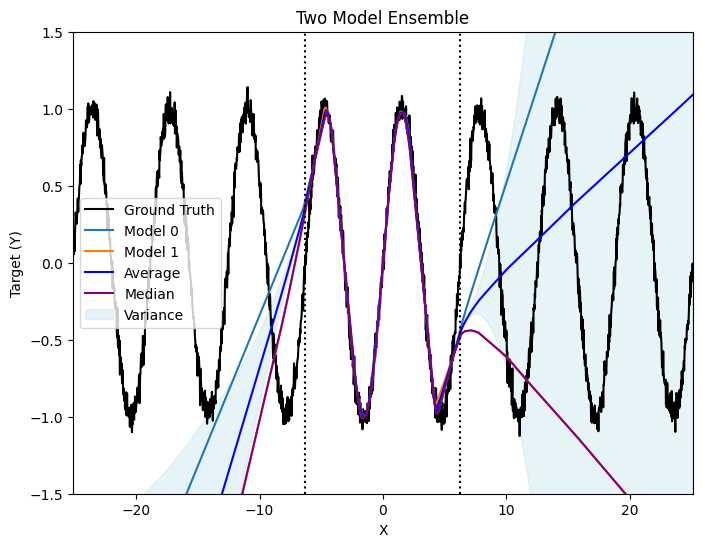

In [21]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, two_model_outputs[0], label="Model 0")
plt.plot(oos_xs, two_model_outputs[1], label="Model 1")

# Plotting Average and Median
plt.plot(oos_xs, two_model_averages, c="blue", label="Average")
plt.plot(oos_xs, two_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for two_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(two_model_averages) - torch.tensor(two_model_var), torch.tensor(two_model_averages) + torch.tensor(two_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)

plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

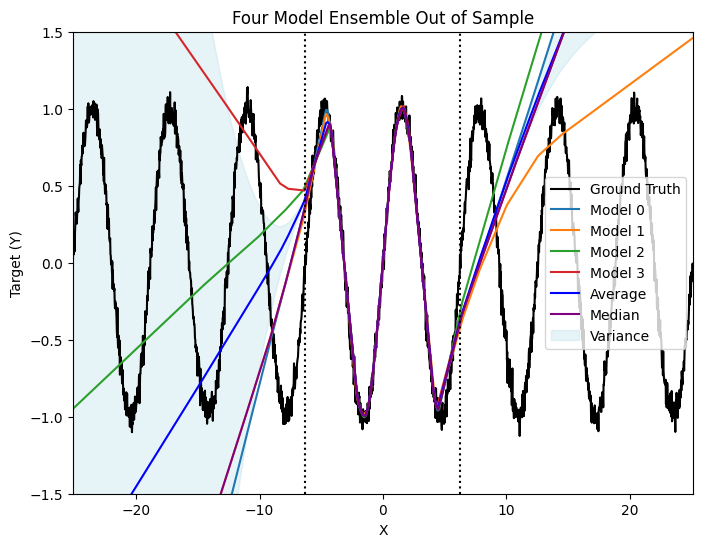

In [22]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")

# Plot individual models
for i, model_output in enumerate(four_model_outputs):
    plt.plot(oos_xs, model_output, label=f"Model {i}")

# Plot posterior predictive (average and median)
plt.plot(oos_xs, four_model_averages, c="blue", label="Average")
plt.plot(oos_xs, four_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for four_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(four_model_averages) - torch.tensor(four_model_var), torch.tensor(four_model_averages) + torch.tensor(four_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.title('Four Model Ensemble Out of Sample')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


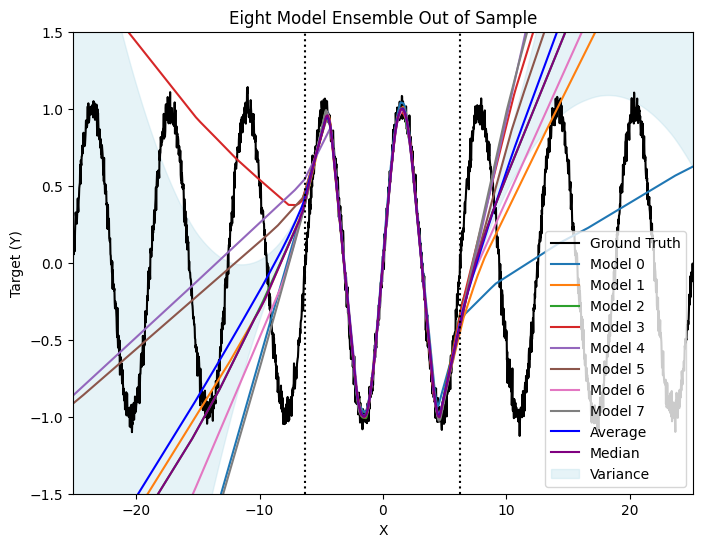

In [23]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")

# Plot individual models
for i, model_output in enumerate(eight_model_outputs):
    plt.plot(oos_xs, model_output, label=f"Model {i}")

# Plot posterior predictive (average and median)
plt.plot(oos_xs, eight_model_averages, c="blue", label="Average")
plt.plot(oos_xs, eight_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for eight_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(eight_model_averages) - torch.tensor(eight_model_var), torch.tensor(eight_model_averages) + torch.tensor(eight_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.title('Eight Model Ensemble Out of Sample')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.